# Predicting 3 classes with Logit



The dataset I will be using is pulled from the GSE76118 project, and was carefully chosen to only contain endothelial cells, atrial CMs, and ventricular CMs. This dataset has 1525 cells as rows, and 29466 genes as column features. I also included the identity classes as a column called ```Celltype$ident```.


I'm hoping by doing this exercise I can understand how to do classification and feature selection, and apply it to my "cleaner" function.

In [1]:
library(leaps)
library(plyr)
library(dplyr)
library(glmnet)
library(data.table)
`%!in%` <- Negate(`%in%`)

setwd("/mnt/c/Users/mkozubov/OneDrive - Tenaya Therapeutics/Desktop/Intuitions/Statistics/Linear_regression/")

Celltype <- fread('./data/example_dataset_for_classficiation.csv', 
                 data.table = FALSE, 
                 check.names = FALSE, 
                 stringsAsFactors = FALSE, 
                 header = TRUE, 
                 sep = ",")
# Fixing rownames
rownames(Celltype) <- Celltype[,1]
Celltype$V1 <- NULL

# I am going to get rid of the Gm genes because I feel they pollute my results
cols.to.remove <- colnames(Celltype)[grepl("^Gm[0-9]{4,9}", colnames(Celltype))]
Celltype <- Celltype[colnames(Celltype) %!in% cols.to.remove]

dim(Celltype)

Warning message:
“package ‘plyr’ was built under R version 4.1.2”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix

Warning message:
“package ‘Matrix’ was built under R version 4.1.2”
Loaded glmnet 4.1-2

Warning message:
“package ‘data.table’ was built under R version 4.1.1”

Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




[1]  1525 20843

Getting the data into X and Y for use with glmnet lasso

In [2]:
X = as.matrix(Celltype[,1:dim(Celltype)[2]-1])
Y = Celltype$ident
rm(Celltype)

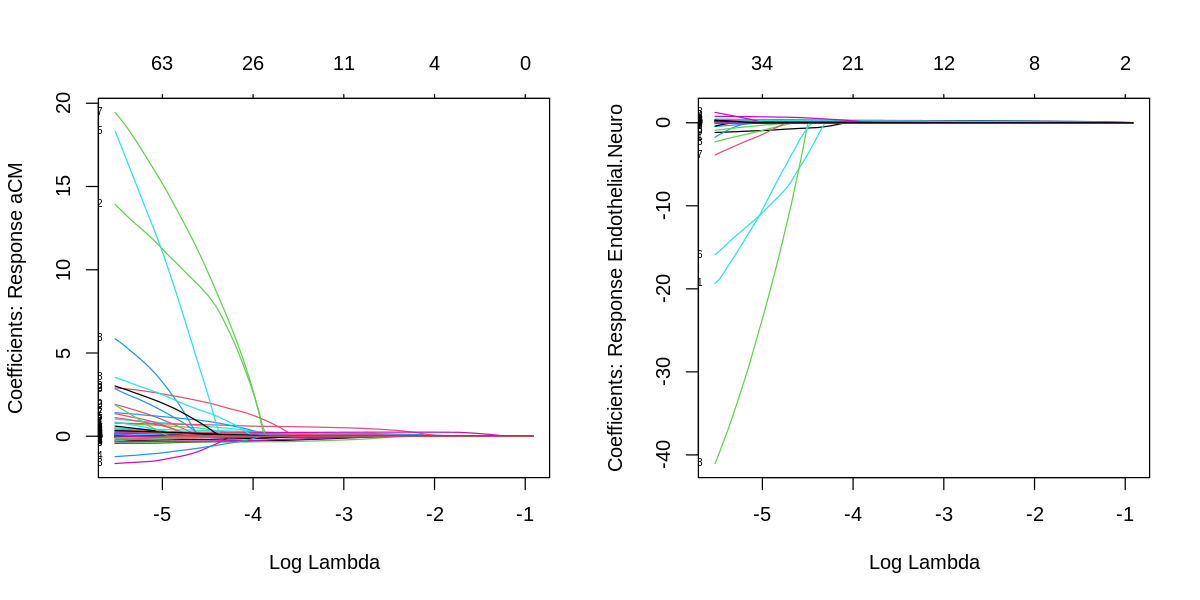

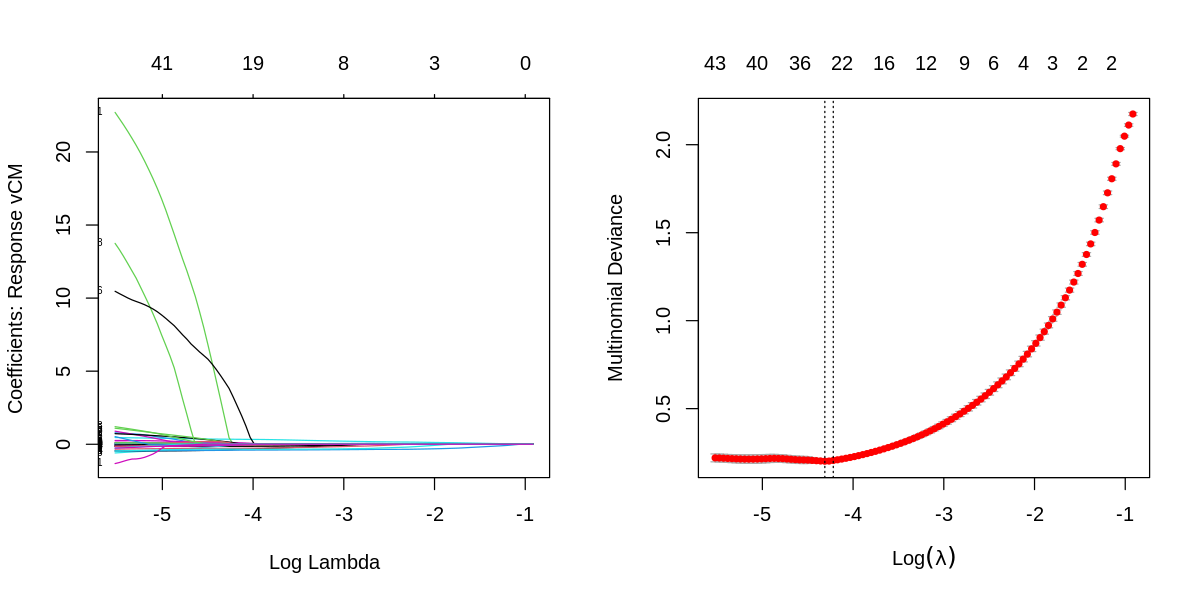

In [3]:
lasso.fit <- glmnet(X,Y, family = 'multinomial')
lasso.cv <- cv.glmnet(X,Y, nfolds=5, family = 'multinomial')

par(mfrow=c(1,2))
options(repr.plot.height=5, repr.plot.width = 10)
plot(lasso.fit, xvar = 'lambda', label=T)
plot(lasso.cv)

In [16]:
outcome <- coef(lasso.cv, s = lasso.cv$lambda.min)
for(n in 1:length(outcome)){
    celltype <- outcome[[n]]
    print(names(outcome)[n])
    print(celltype[celltype[,1]!=0,])
}

[1] "aCM"
  (Intercept)         Hmgn2          Cav1          Myl2          Hey2 
 0.9844039420 -0.3195469528  0.1339197508 -0.0471978524 -0.0663876124 
       Tubal3         Fgf12      Hsp90ab1        Spink1           Gal 
 6.8276788758  0.0483856397 -0.3376909693  0.4954275219  0.0272304401 
      Tmem163          Pigr         Itga6         Kcnc4        Tgfbr3 
 0.0235062121 -0.1798604588  0.0435733015  0.2470698676 -0.0672207223 
        Pcsk6         Nr2f2          Rpsa         Lars2          Eif1 
-0.0008297792  0.1091504116 -0.1633667483 -0.0138399216  0.1176261583 
          Pln         Cbln3        Lrrc4b        Cyp4x1       Tmem196 
-0.2674784630  1.7380806279  0.6620224256  0.0620272136  0.7208733738 
       Tceal8         Vsnl1         Foxd2       Ccdc154          Myl1 
 0.3233171222  0.2382488436  7.4947163836  0.0469936792  0.2146311311 
     Rpl9.ps6     Serpina3b         Nr2f1      Rpl3.ps1         L1td1 
-0.0047210202 -0.4613836158  0.0334692190 -0.0215980631  0.05247014

In [18]:
# Curious about the atrial and ventricular intersect
aCM <- outcome[[1]][outcome[[1]][,1]!=0,]
vCM <- outcome[[3]][outcome[[3]][,1]!=0,]
intersect(names(aCM), names(vCM))

[1] "(Intercept)" "Myl2"        "Hey2"        "Pcsk6"       "Nr2f2"      
[6] "Rpsa"        "Pln"

# Conclusion
Okay, I think I have a classifier that can differentiate between endothelial cells, atrial CMs, and ventricular CMs based on the genes listed above. Unforntunately now I am unsure of how to proceed to create the rest of my model!

## Steps of my model
1. Learn what 2 pure celltypes should look like
2. When given a single cell, determine what percentage of each pure celltype has been mixed together to create this single cell.

## Issues
1. I trained my data on 1 full cell, how can I transfer this model to work on any quantity of mixture? I'm not understanding how I can determine that 1 cell is a mixture of 2 cells. Probably will need some normalization
2. I trained on normalized data, should I have read in counts, then normalized myself? I did remove about 300 Gm genes.
3. I have a classifier made with Lasso coefficients, but they aren't very interpretable besides telling me which genes are the important ones for classification. How do I take this model (or series of models, I got a list of 3) and somehow interpret the results as saying a cell is a weighted average of two other celltypes.
